# Softmax

In [1]:
%matplotlib inline
import math 
import random

import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def ind_max(x):
    m = max(x)
    return x.index(m)

In [55]:
def categorical_draw(probs): 
    z = random.random() 
    cum_prob = 0.0 
    for i in range(len(probs)): 
        prob = probs[i] 
        cum_prob += prob 
        if cum_prob > z: 
            return i
    return len(probs) - 1

In [78]:
p = [0.1, 0.2, 0.3, 0.4]

In [79]:
x = []
for i in range(100000):
    x.append(categorical_draw(p))

from collections import Counter
c = Counter(x)
c.most_common()

[(3, 39998), (2, 29936), (1, 20018), (0, 10048)]

In [129]:
random.choices(range(len(p)), weights=p)

[2]

In [132]:
arms = [i for i in range(len(p))]

x = []
for i in range(100000):
    x.append(random.choices(range(len(p)), weights=p)[0])

from collections import Counter
c = Counter(x)
c.most_common()

[(3, 40274), (2, 29690), (1, 19972), (0, 10064)]

In [167]:
def categorical_draw(probs):
    return random.choices(range(len(probs)), probs)[0]

In [4]:
class Softmax: 
    def __init__(self, temperature, counts, values): 
        self.temperature = temperature 
        self.counts = counts 
        self.values = values 
        return
    
    def initialize(self, n_arms): 
        self.counts = [0 for col in range(n_arms)] 
        self.values = [0.0 for col in range(n_arms)] 
        return
    
    def select_arm(self): 
        z = sum([math.exp(v / self.temperature) for v in self.values]) 
        probs = [math.exp(v / self.temperature) / z for v in self.values] 
        return categorical_draw(probs)
    
    def update(self, chosen_arm, reward): 
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1 
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm] 
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward 
        self.values[chosen_arm] = new_value 
        return

In [6]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

In [7]:
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
            algo.update(chosen_arm, reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [57]:
random.seed(1) 
means = [0.1, 0.1, 0.1, 0.1, 0.9] 
n_arms = len(means) 
random.shuffle(means) 
arms = [BernoulliArm(mu) for mu in means] 
print("Best arm is " + str(ind_max(means)))
f = open("standard_softmax_results.tsv", "w")

for temperature in [0.1, 0.2, 0.3, 0.4, 0.5]: 
    algo = Softmax(temperature, [], []) 
    algo.initialize(n_arms) 
    results = test_algorithm(algo, arms, 5000, 250) 
    for i in range(len(results[0])): 
        f.write(str(temperature) + "\t") 
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()

Best arm is 2


In [67]:
df = pd.read_csv('./standard_softmax_results.tsv', sep='\t', header=None, 
                     names=["Temperature", "Sim", "T", "ChosenArm", "Reward", "CumulativeReward"])

In [8]:
def plot_prob_best_arm(df, best_arm):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df[df['ChosenArm'].eq(best_arm)].groupby(['T', 'Temperature'])['ChosenArm'].count().to_frame()
    xseries = xseries['ChosenArm'].apply(lambda x: x/5000).unstack().plot(ax=ax)
    xseries.set_ylabel(f"Probability of selecting best arm ({best_arm})")
    xseries.set_xlabel("Turn")
    
def plot_avg_reward(df):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df.groupby(['T', 'Temperature'])['Reward'].mean().unstack().plot(ax=ax)
    xseries.set_ylabel("Average reward")
    xseries.set_xlabel("Turn")

def plot_cumulative_reward(df):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df.groupby(['T', 'Temperature'])['CumulativeReward'].mean().unstack().plot(ax=ax)
    xseries.set_ylabel("Cumulative reward")
    xseries.set_xlabel("Turn")

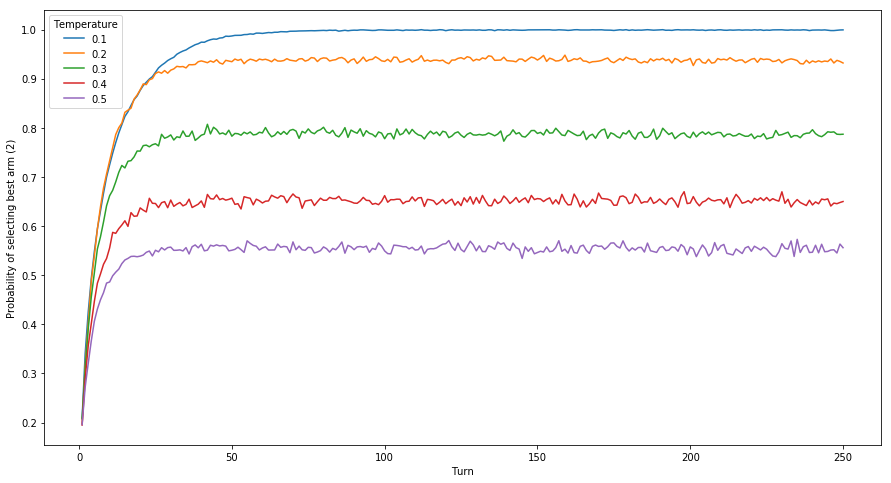

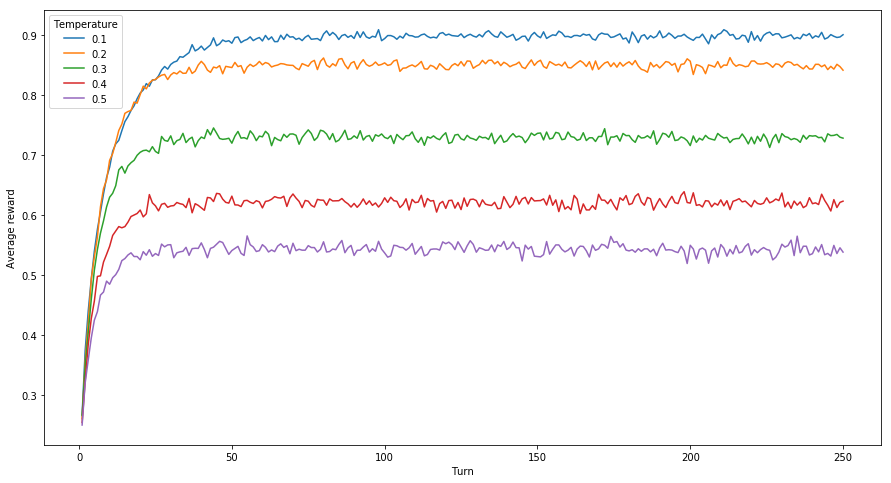

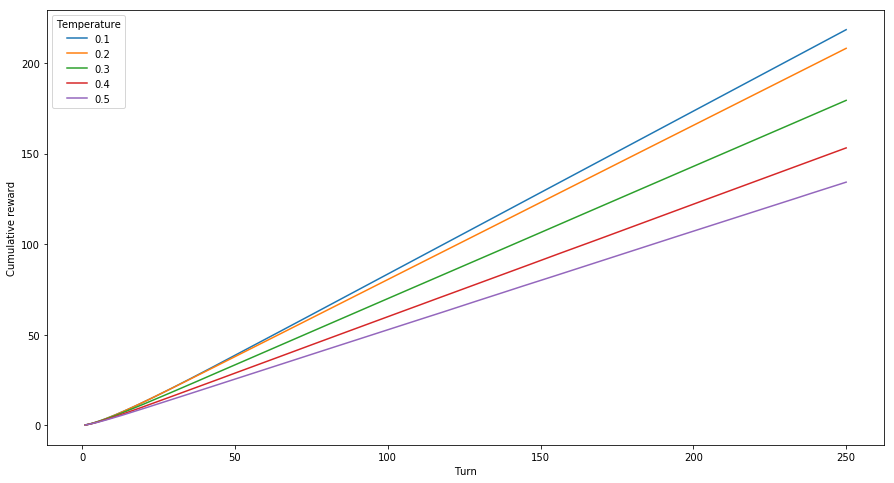

In [69]:
plot_prob_best_arm(df, 2)
plot_avg_reward(df)
plot_cumulative_reward(df)

# Annealing

In [9]:
import numpy as np

### How does temperature vary with time

In [168]:
t = [x for x in range(2, 1000)]
y = [(1 / math.log(t + 0.0000001)) for t in range(2, 1000)]

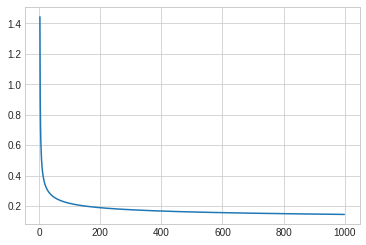

In [169]:
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()

ax.plot(t, y)

## Annealing

In [12]:
class AnnealingSoftmax: 
    
    def __init__(self, counts, values): 
        self.counts = counts 
        self.values = values 
        return
    
    def initialize(self, n_arms): 
        self.counts = [0 for col in range(n_arms)] 
        self.values = [0.0 for col in range(n_arms)] 
        return

    def select_arm(self): 
        t = sum(self.counts) + 1
        temperature = 1 / math.log(t + 0.0000001)
        z = sum([math.exp(v / temperature) for v in self.values]) 
        probs = [math.exp(v / temperature) / z for v in self.values] 
        return categorical_draw(probs)

    def update(self, chosen_arm, reward): 
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1 
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm] 
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward 
        self.values[chosen_arm] = new_value 
        return

In [76]:
random.seed(1) 
means = [0.1, 0.1, 0.1, 0.1, 0.9] 
n_arms = len(means) 
random.shuffle(means) 
arms = [BernoulliArm(mu) for mu in means] 
print("Best arm is " + str(ind_max(means)))
f = open("standard_annealing_results.tsv", "w")

algo = AnnealingSoftmax([], []) 
algo.initialize(n_arms) 
results = test_algorithm(algo, arms, 5000, 250) 
for i in range(len(results[0])): 
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()

Best arm is 2


In [77]:
df = pd.read_csv('./standard_annealing_results.tsv', sep='\t', header=None,
                     names=["Sim", "T", "ChosenArm", "Reward", "CumulativeReward"])

In [78]:
df.head()

,Sim,T,ChosenArm,Reward,CumulativeReward
0,1,1,2,1.0,1.0
1,1,2,2,1.0,2.0
2,1,3,0,1.0,3.0
3,1,4,3,0.0,3.0
4,1,5,2,1.0,4.0


In [87]:
def plot_prob_best_arm(df, best_arm):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df[df['ChosenArm']==best_arm].groupby('T')['ChosenArm'].count().apply(lambda x:x/5000)
    xseries = xseries.plot()
    xseries.set_ylabel(f"P({best_arm})")
    xseries.set_xlabel("Turn")
def plot_avg_reward(df):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df.groupby(['T'])['Reward'].mean().plot(ax=ax)
    xseries.set_ylabel("Average reward")
    xseries.set_xlabel("Turn")

def plot_cumulative_reward(df):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df.groupby(['T'])['CumulativeReward'].mean().plot(ax=ax)
    xseries.set_ylabel("Cumulative reward")
    xseries.set_xlabel("Turn")

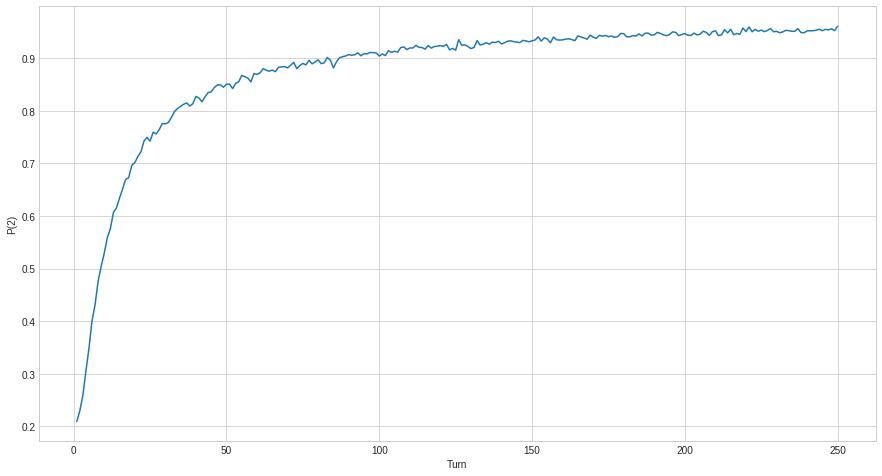

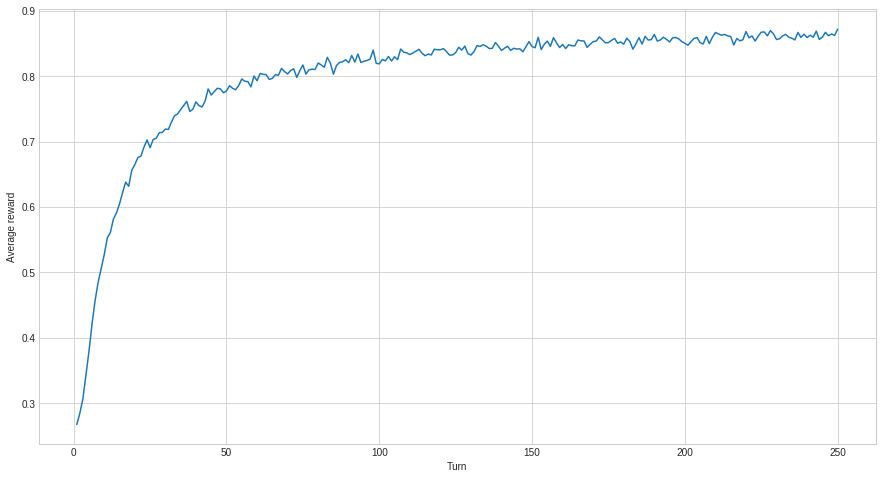

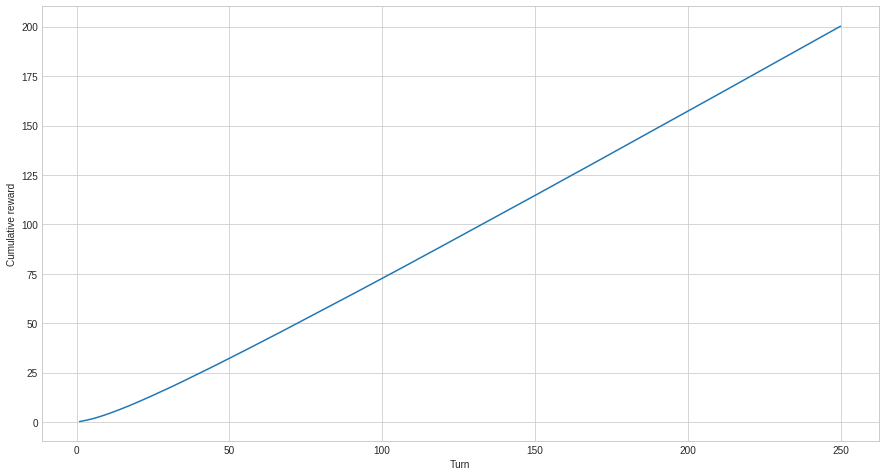

In [88]:
plot_prob_best_arm(df, 2)
plot_avg_reward(df)
plot_cumulative_reward(df)